In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

/Users/ryankirkland/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv('nlp_cleaned_reviews.csv')

In [3]:
df['sentiment'] = df['rating'].map({1.0: 'Negative', 2.0: 'Negative', 3.0: 'Neutral', 4.0: 'Positive', 5.0: 'Positive'})

In [4]:
df = df.drop('Unnamed: 0', axis=1)

In [50]:
df.shape

(4745, 14)

In [5]:
holdout_df = df[df['sentiment'] == 'Neutral']

In [6]:
test_df = df[df['sentiment'] != 'Neutral']
test_df.loc[:,'str_desc'] = test_df.loc[:,'str_desc'].fillna('null')
test_df['str_desc'].isnull().any()

/Users/ryankirkland/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


False

In [7]:
X = test_df['str_desc']
y = test_df['rating']

In [8]:
tfidf = TfidfVectorizer()
vectorized = tfidf.fit_transform(X)

In [51]:
len(vectorized.toarray()[0])

7918

In [10]:
print(vectorized)

  (0, 2488)	0.04638674906393227
  (0, 1481)	0.05914728905781805
  (0, 7896)	0.09983443113231168
  (0, 3834)	0.11118320436734135
  (0, 1890)	0.07432892705142874
  (0, 4187)	0.07083673927727326
  (0, 3033)	0.10732996838425193
  (0, 7214)	0.08962626818467803
  (0, 1479)	0.04521957846753405
  (0, 889)	0.08225890490159021
  (0, 5865)	0.05576079289591428
  (0, 6229)	0.060497475013483966
  (0, 3794)	0.08876183422873749
  (0, 3054)	0.0964683061949163
  (0, 5558)	0.042525884333342014
  (0, 3048)	0.10732996838425193
  (0, 4189)	0.08511953295988664
  (0, 4996)	0.07432892705142874
  (0, 7809)	0.11661403546200917
  (0, 6739)	0.07827749494964838
  (0, 2036)	0.11118320436734135
  (0, 2775)	0.06101468512247885
  (0, 6284)	0.06356259677722333
  (0, 946)	0.08278423017443975
  (0, 3082)	0.058432768856211535
  :	:
  (4441, 7275)	0.30379261275303326
  (4441, 4113)	0.28509769731581996
  (4441, 4817)	0.23257726255817063
  (4441, 1338)	0.25305777360938375
  (4441, 1578)	0.5455673426391456
  (4441, 2074)	0.165

In [17]:
y_labeled = test_df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(vectorized, y_labeled)

In [133]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, min_samples_split=8, max_depth=None)

In [134]:
rf.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=8)

In [135]:
y_pred_proba = rf.predict_proba(X_test)
y_pred = rf.predict(X_test)

In [136]:
y_pred_proba
y_pred

array(['Positive', 'Positive', 'Positive', ..., 'Positive', 'Positive',
       'Positive'], dtype=object)

In [137]:
rf.score(X_test, y_test)

0.8676867686768677

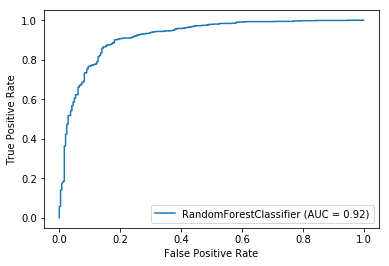

In [138]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(rf, X_test, y_test)

In [126]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

In [127]:
confusion_matrix(y_test, y_pred, labels=['Negative', 'Positive'])

array([[104, 139],
       [ 11, 857]])

In [90]:
feature_importances = np.argsort(rf.feature_importances_)

vect_df.columns[3460]
vect_df.columns[2844]

'ever'

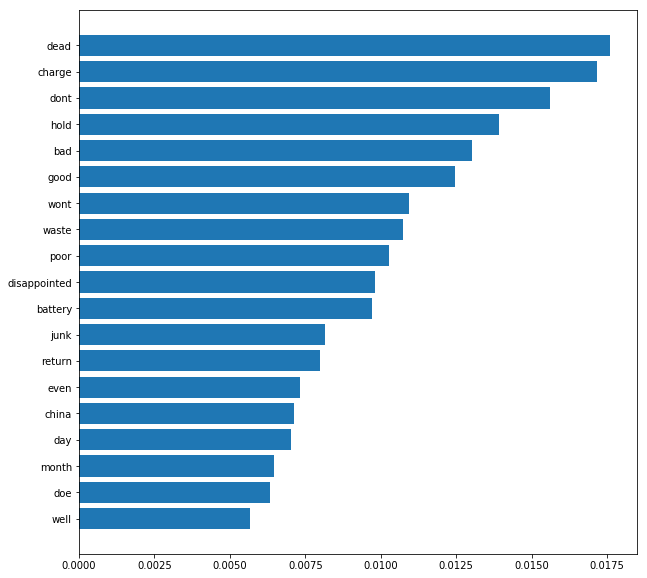

In [73]:
import matplotlib.pyplot as plt

vect_df = pd.DataFrame(vectorized.toarray(), columns=tfidf.get_feature_names())

fig, ax = plt.subplots(figsize=(10,10))
ax.barh(vect_df.columns[feature_importances][-20:-1], rf.feature_importances_[feature_importances][-20:-1]);

In [27]:
import shap

shap.initjs()

In [28]:
explainer = shap.TreeExplainer(rf, shap.sample(X_train.todense(), 100))

In [103]:
shap_values = explainer.shap_values(X_test.todense())

 99%|===================| 2208/2222 [01:53<00:00]        

In [79]:
shap.force_plot(explainer.expected_value[0], shap_values[0], np.array(X_test.todense())[0])

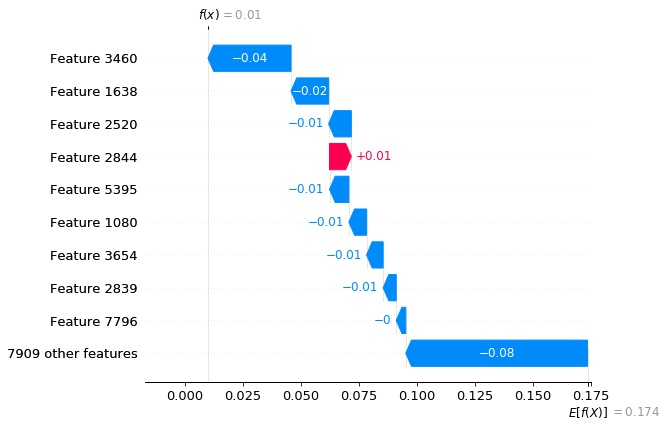

In [97]:
shap.waterfall_plot(explainer.expected_value[0], shap_values[0][0], max_display=10)

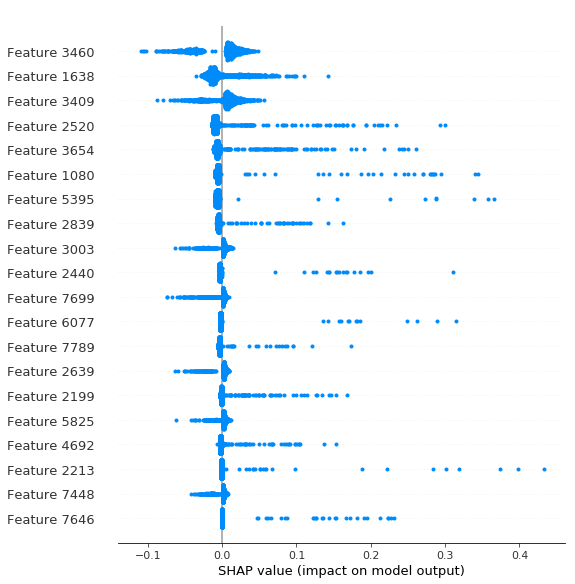

In [154]:
shap.summary_plot(shap_values[0], plot_type='dot')

In [88]:
shap_values[0]

array([[-9.99999978e-05,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  6.66666683e-05]])

In [37]:
explainer.expected_value[0]

0.17360000000000003

In [ ]:
from sklearn.naive_bayes import MultinomialNB

clf_nb = MultinomialNB()
clf_nb.fit(X_train, y_train)

In [ ]:
clf_nb.predict(X_test)

In [ ]:
clf_nb.score(X_test, y_test)

In [ ]:
len(tfidf.get_feature_names())

In [ ]:
vect_df